In [1]:
!pip install pandas numpy matplotlib seaborn yfinance


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data = yf.download("NVDA", start="2024-08-27", end="2025-09-07")
data.head()

C:\Windows\Temp\ipykernel_27280\94910598.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("NVDA", start="2024-08-27", end="2025-09-07")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2024-08-27,128.259491,129.159201,123.840881,125.010517,303134600
2024-08-28,125.570335,128.289478,122.601272,128.079537,448101100
2024-08-29,117.552864,124.390708,116.673145,121.321678,453023300
2024-08-30,119.332306,121.711552,117.182983,119.492251,333751600
2024-09-03,107.965889,116.173295,107.256114,115.973361,477155100


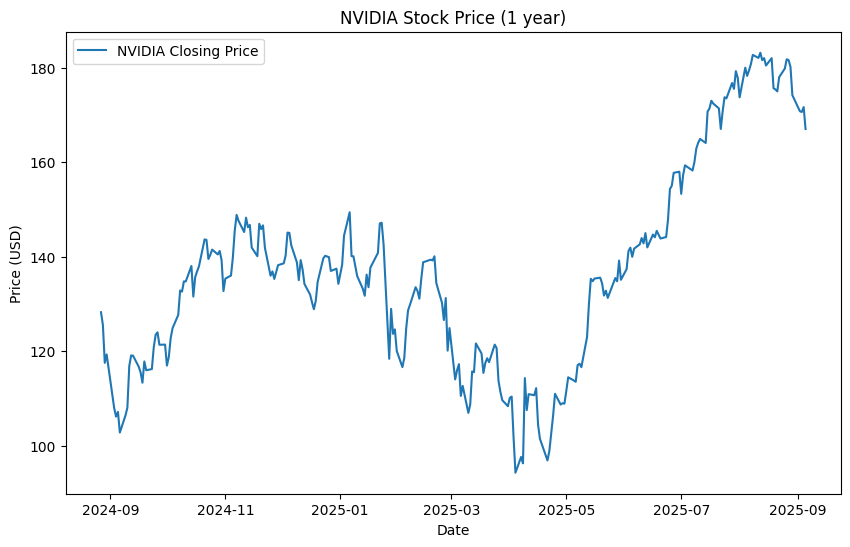

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(data["Close"], label="NVIDIA Closing Price")
plt.title("NVIDIA Stock Price (1 year)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

In [5]:
from sklearn.preprocessing import MinMaxScaler
SEQ_LENGTH = 60 #days modle will look at
close = data[['Close']].dropna().astype(float) #take close column, drop Nans and type convert
split_idx = int(len(close) * 0.8) #split index so we train first 80%
scaler = MinMaxScaler(feature_range=(0,1)) #range will be 0-1
scaler.fit(close.iloc[:split_idx]) #fit scalar on train (no looking at future)
close_scaled = pd.DataFrame(
    scaler.transform(close),
    index = close.index,
    columns=['Close_Scaled']
)

print("Scaled head:\n", close_scaled.head(), "\n")
print("Scaled tail:\n", close_scaled.tail(), "\n")
print("Scaled min/max:", float(close_scaled.min()), float(close_scaled.max()))


Scaled head:
             Close_Scaled
Date                    
2024-08-27      0.616235
2024-08-28      0.567432
2024-08-29      0.421931
2024-08-30      0.454224
2024-09-03      0.247946 

Scaled tail:
             Close_Scaled
Date                    
2025-08-29      1.449601
2025-09-02      1.387898
2025-09-03      1.384994
2025-09-04      1.403869
2025-09-05      1.319662 

Scaled min/max: 0.0 1.6125708630280526


C:\Windows\Temp\ipykernel_27280\1823170304.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print("Scaled min/max:", float(close_scaled.min()), float(close_scaled.max()))


In [6]:
import numpy as np
def create_sequences(values_2d, seq_length=60):
    #converts 2d array of values into sequences for time series preditction
    X, y = [], [] #inputs, target
    for i in range(len(values_2d) - seq_length):
        X.append(values_2d[i:i+seq_length])
        y.append(values_2d[i+seq_length]) #target is day after sequence
    return np.array(X), np.array(y) #converts python list to numpy array
values = close_scaled.values
X_all, y_all = create_sequences(values, SEQ_LENGTH)
#based off of the last 60 days what would day 61 be?

In [7]:
train_samples = split_idx - SEQ_LENGTH #end of training data - min days of history
X_train = X_all[:train_samples] #first portion is training data
y_train = y_all[:train_samples] 
X_test = X_all[train_samples:] #remaining is test data, used for checking
y_test = y_all[train_samples:]


In [8]:
import torch
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
#convert numpy arrays to torch tensors , 32bit floats
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [9]:
import torch.nn as nn
class StockLSTM(nn.Module): #nn is base class
    def __init__(self, input_size = 1, hidden_size = 50, num_layers = 2, output_size = 1):
        #closing price, how many neurons that learn patterns, stack 2 LSTM for complex patterns
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        #handles sequential data
        self.fc = nn.Linear(hidden_size, output_size)
        #converts LSTM hidden state to final prediction
    def forward(self, x): #used to tell putorch how to computer predictions after passing in data
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # hidden state lstm short term memory
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # cell state for lstm long term memory
        #one state per layer, batch size(how many sequences we can process at once), number of neurons in each lstm layer
        out, _ = self.lstm(x, (h0, c0))
        #takes input x of shape [batch size, seq length, features]
        #produces out of shape [batch size, seq length, hidden length]
        # translation = for each day in the 60-day window the lstm produxes a 50 dimentional pattern vector
        out = self.fc(out[:, -1,:]) #get output from last day in sequence
        return out
model = StockLSTM(input_size=1, hidden_size=50, num_layers=2, output_size=1).to(device)
print(model)



StockLSTM(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)
